# Qubitization Walk Operator

Bloqs for constructing quantum walks from Select and Prepare operators.

The spectrum of a quantum Hamiltonian can be encoded in the spectrum of a quantum "walk"
operator. The Prepare and Select subroutines are carefully designed so that the Hamiltonian
$H$ is encoded as a projection of Select onto the state prepared by Prepare:

$$
\mathrm{PREPARE}|0\rangle = |\mathcal{L}\rangle \\
(\langle \mathcal{L} | \otimes \mathbb{1}) \mathrm{SELECT} (|\mathcal{L} \rangle \otimes \mathbb{1}) = H / \lambda
$$.
We first document the SelectOracle and PrepareOracle abstract base bloqs, and then show
how they can be combined in `QubitizationWalkOperator`.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `SelectOracle`
Abstract base class that defines the interface for a SELECT Oracle.

The action of a SELECT oracle on a selection register $|l\rangle$ and target register
$|\Psi\rangle$ can be defined as:

$$
    \mathrm{SELECT} = \sum_{l}|l \rangle \langle l| \otimes U_l
$$

In other words, the `SELECT` oracle applies $l$'th unitary $U_l$ on the target register
$|\Psi\rangle$ when the selection register stores integer $l$.

$$
    \mathrm{SELECT}|l\rangle |\Psi\rangle = |l\rangle U_{l}|\Psi\rangle
$$

In [2]:
from qualtran.bloqs.multiplexers.select_base import SelectOracle

## `PrepareOracle`
Abstract base class that defines the API for a PREPARE Oracle.

Given a set of coefficients $\{c_0, c_1, ..., c_{N - 1}\}$, the PREPARE oracle is used to encode
the coefficients as amplitudes of a state $|\Psi\rangle = \sum_{l=0}^{N-1} \sqrt{\frac{c_l}{\lambda}} |l\rangle$
where $\lambda = \sum_l |c_l|$, using a selection register $|l\rangle$. In order to prepare such
a state, the PREPARE circuit is also allowed to use a junk register that is entangled with
selection register.

Thus, the action of a PREPARE circuit on an input state $|0\rangle$ can be defined as:

$$
    \mathrm{PREPARE} |0\rangle = \sum_{l=0}^{N-1} \sqrt{ \frac{c_l}{\lambda} } |l\rangle |\mathrm{junk}_l\rangle
$$

In [3]:
from qualtran.bloqs.state_preparation.prepare_base import PrepareOracle

## `QubitizationWalkOperator`
Construct a Szegedy Quantum Walk operator using LCU oracles SELECT and PREPARE.

For a Hamiltonian $H = \sum_l w_l H_l$ (where coefficients $w_l > 0$ and $H_l$ are unitaries),
This bloq constructs a Szegedy quantum walk operator $W = R_{L} \cdot \mathrm{SELECT}$,
which is a product of two reflections:
 - $R_L = (2|L\rangle\langle L| - I)$ and
 - $\mathrm{SELECT}=\sum_l |l\rangle\langle l|H_l$.

The action of $W$ partitions the Hilbert space into a direct sum of two-dimensional irreducible
vector spaces giving it the name "qubitization".
For an arbitrary eigenstate $|k\rangle$ of $H$ with eigenvalue $E_k$,
the two-dimensional space is spanned by $|L\rangle|k\rangle$ and
an orthogonal state $\phi_k$. In this space, $W$ implements a Pauli-Y rotation by an angle of
$-2\arccos(E_k / \lambda)$ where $\lambda = \sum_l w_l$. That is,
$W = e^{i \arccos(E_k / \lambda) Y}$.

Thus, the walk operator $W$ encodes the spectrum of $H$ as a function of eigenphases of $W$,
specifically $\mathrm{spectrum}(H) = \lambda \cos(\arg(\mathrm{spectrum}(W)))$
where $\arg(e^{i\phi}) = \phi$.

#### Parameters
 - `select`: The SELECT lcu gate implementing $\mathrm{SELECT}=\sum_{l}|l\rangle\langle l|H_{l}$.
 - `prepare`: Then PREPARE lcu gate implementing $\mathrm{PREPARE}|0\dots 0\rangle = \sum_l \sqrt{\frac{w_{l}}{\lambda}} |l\rangle = |L\rangle$
 - `control_val`: If 0/1, a controlled version of the walk operator is constructed. Defaults to None, in which case the resulting walk operator is not controlled. 

#### References
 - [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662). Babbush et. al. (2018). Figure 1.


In [4]:
from qualtran.bloqs.qubitization import QubitizationWalkOperator

### Example Instances

In [5]:
from qualtran.bloqs.chemistry.ising.walk_operator import get_walk_operator_for_1d_ising_model

walk_op, _ = get_walk_operator_for_1d_ising_model(4, 2e-1)

In [6]:
from openfermion.resource_estimates.utils import QI

from qualtran.bloqs.chemistry.thc.prepare_test import build_random_test_integrals
from qualtran.bloqs.chemistry.thc.walk_operator import get_walk_operator_for_thc_ham

# Li et al parameters from openfermion.resource_estimates.thc.compute_cost_thc_test
num_spinorb = 152
num_bits_state_prep = 10
num_bits_rot = 20
thc_dim = 450
num_spat = num_spinorb // 2
t_l, eta, zeta = build_random_test_integrals(thc_dim, num_spinorb // 2, seed=7)
qroam_blocking_factor = np.power(2, QI(thc_dim + num_spat)[0])
thc_walk_op = get_walk_operator_for_thc_ham(
    t_l,
    eta,
    zeta,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_theta=num_bits_rot,
    kr1=qroam_blocking_factor,
    kr2=qroam_blocking_factor,
)

In [7]:
from qualtran.bloqs.chemistry.sparse.prepare_test import build_random_test_integrals
from qualtran.bloqs.chemistry.sparse.walk_operator import get_walk_operator_for_sparse_chem_ham

num_spin_orb = 8
num_bits_rot_aa = 8
num_bits_state_prep = 12
tpq, eris = build_random_test_integrals(num_spin_orb // 2)
walk_op_chem_sparse = get_walk_operator_for_sparse_chem_ham(
    tpq, eris, num_bits_rot_aa=num_bits_rot_aa, num_bits_state_prep=num_bits_state_prep
)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([walk_op, thc_walk_op, walk_op_chem_sparse],
           ['`walk_op`', '`thc_walk_op`', '`walk_op_chem_sparse`'])

### Call Graph

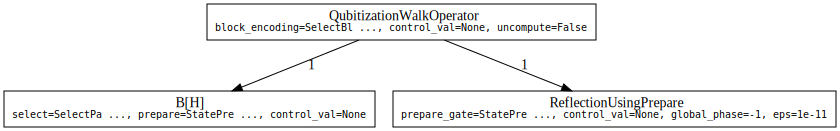

#### Counts totals:
 - `B[H]`: 1
 - `ReflectionUsingPrepare`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
walk_op_g, walk_op_sigma = walk_op.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(walk_op_g)
show_counts_sigma(walk_op_sigma)